# Processing of the results

First some imports

In [2]:
import os

from gravann.input import csv_reader
from gravann.functions import unit_conversion

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import ast
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Processing and Data Visualization

In [3]:
sample = "eros"
output_directory = Path(f"./results/{sample}")
error_of_interest = "relRMSE"
input_csv_file = output_directory.joinpath(f"total_results_{sample}.csv")

one_km = unit_conversion.convert_altitude(sample, np.array([1.0]), forward=False, unit='km')[0]


noise_replacement = {
    "['']" : "No Noise",
    "['constant_bias', [9.79917e-05, 0.0, 0.0]]": "Constant Bias $c = 9.799 \cdot 10^{-5}$",
    "['gaussian', 0.0, 0.009337]": "Additive Gaussian $\mu = 0 \; \sigma= 0.009$",
    "['gaussian', 0.0, 0.093371]": "Additive Gaussian $\mu = 0 \; \sigma= 0.093$",
    "['adaptive_gaussian_noise', 0.001]": "Multiplicative Gaussian $\mu = 1 \; \sigma= 0.001$",
    "['adaptive_gaussian_noise', 0.01]": "Multiplicative Gaussian $\mu = 1 \; \sigma= 0.01$",
    "['adaptive_gaussian_noise', 0.1]": "Multiplicative Gaussian $\mu = 1 \; \sigma= 0.1$"
}

sample_distance_replacement = {
    "[0. 1.]": "$(0, 1)$",
    "[1. 3.]": "$(1, 3)$",
    "[3. 5.]": "$(3, 5)$",
}

In [6]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.009337, [9.79917e-05, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 0.093371, [9.79917e-05, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["iterations"] == 10000) & (df["pretrained_model"] == "None") & (df["resolution"] == "100%") & (df["noise"] == "['']") & (df["sample_domain"] == "[0.0, 1.0]") & (df["integration_points"] == 300000)]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "pretrained_model", "seed", "resolution", "sample_domain", "noise", "iterations", "integration_points"], inplace=True)

In [7]:
df.groupby(["ground_truth"]).mean()

,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0
ground_truth,,,,,,,,,,
mascon,0.068542,0.083236,0.019613,0.003636,0.001668,0.000567,0.000749,0.000030,0.000014,0.000003
polyhedral,0.048568,0.040658,0.012992,0.001861,0.000500,0.000327,0.000643,0.000016,0.000007,0.000001


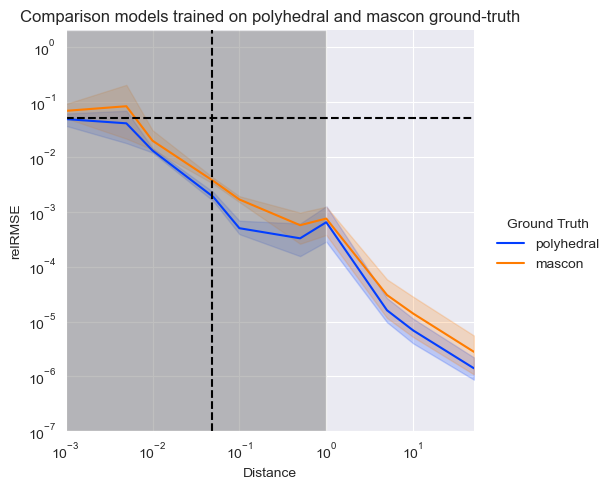

In [8]:
dfm = df.melt(["ground_truth"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))
dfm.rename(columns={"ground_truth": "Ground Truth"}, inplace=True)

g = sns.relplot(
    data=dfm, kind="line",
    x="Distance", y=error_of_interest,
    hue="Ground Truth", palette="bright", hue_order=["polyhedral", "mascon"]
)
g.set(
    xlim=(0.001, 50.0), xscale='log', yscale='log', ylim=(1e-7, 2.0),
    title="Comparison models trained on polyhedral and mascon ground-truth",
)


g.map(plt.axhline, y=0.05, ls='--', c='black', label="5%")
g.map(plt.axvline, x=one_km, ls='--', c='black', label="1 km")

for ax in g.axes[:,0]:
    ax.axvspan(0, 1.0, facecolor='gray', alpha=0.5)


g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_mascon_polyhedral.png")
g.savefig(save_path, dpi=300)

In [11]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.009337, [9.79917e-05, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 0.093371, [9.79917e-05, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["ground_truth"] == "polyhedral") & (df["resolution"] == "100%") & (df["noise"] == "['']") & (df["sample_domain"] == "[3.0, 5.0]") & (df["integration_points"] == 300000) & (df["iterations"] != 1000) & (df["iterations"] != 10000)]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "seed", "resolution", "sample_domain", "noise", "integration_points"], inplace=True)

In [12]:
df.groupby(["iterations", "pretrained_model"]).mean()

0.001     0.005      0.01      0.05       0.1  \
iterations pretrained_model                                                     
10         0.1%              0.544238  0.690461  0.498025  0.331048  0.281238   
           1%                0.268543  0.255088  0.249681  0.130413  0.117196   
           10%               0.350145  0.353158  0.307141  0.248005  0.231456   
           None              1.047350  1.044305  1.031341  1.025516  0.949483   
100        0.1%              0.673327  0.645820  0.651448  0.505298  0.432457   
           1%                0.728861  0.499269  0.640350  0.495245  0.393024   
           10%               0.350232  0.360210  0.337659  0.246586  0.230963   
           None              1.035546  0.980550  1.009211  0.947366  0.821482   

                                  0.5       1.0       5.0      10.0      50.0  
iterations pretrained_model                                                    
10         0.1%              0.218415  0.143375  0.013867  0.006395  0.001238  
           1%                0.124648  0.096258  0.007882  0.003521  0.000662  
           10%               0.216428  0.135218  0.011962  0.005554  0.001106  
           None              0.587901  0.253813  0.015978  0.007320  0.001391  
100        0.1%              0.358443  0.125651  0.000883  0.000304  0.000061  
           1%                0.222647  0.093928  0.001146  0.000517  0.000105  
           10%               0.214746  0.135215  0.011933  0.005552  0.001109  
           None              0.522496  0.187607  0.001110  0.000254  0.000046

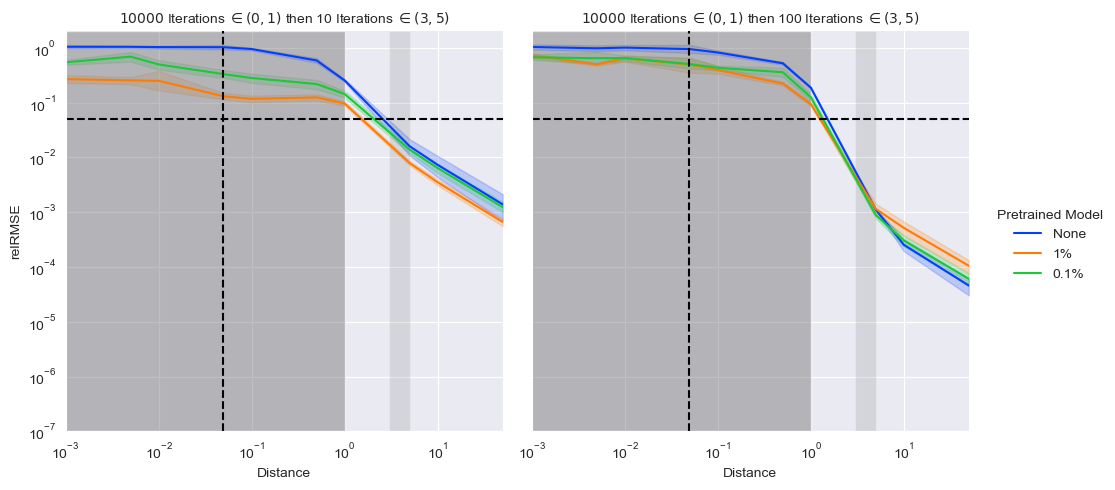

In [6]:
dfm = df.melt(["iterations", "pretrained_model"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))

dfm.rename(columns={"iterations": "Fine-Tuning Iterations", "pretrained_model": "Pretrained Model"}, inplace=True)

g = sns.relplot(
    data=dfm, kind="line",
    col="Fine-Tuning Iterations",
    x="Distance", y=error_of_interest,
    hue="Pretrained Model", palette="bright", hue_order=["None", "1%", "0.1%"]
)
g.set(
    xlim=(0.001, 50.0), xscale='log', yscale='log', ylim=(1e-7, 2.0)
)

g.set_titles("$10 000$ Iterations $\in (0,1)$ then {col_name} Iterations $\in (3,5)$")

g.map(plt.axhline, y=0.05, ls='--', c='black', label="5%")
g.map(plt.axvline, x=one_km, ls='--', c='black', label="1 km")

for ax in g.axes[0,:]:
    ax.axvspan(0, 1.0, facecolor='gray', alpha=0.5)
    ax.axvspan(3.0, 5.0, facecolor='gray', alpha=0.2)

g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_pretrain_iterations.png")
g.savefig(save_path, dpi=300)

In [7]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.009337, [9.79917e-05, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 0.093371, [9.79917e-05, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["ground_truth"] == "polyhedral") & (df["resolution"] == "100%") & (df["noise"] == "['']") & (df["pretrained_model"] == "None")]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "seed", "resolution", "noise", "ground_truth"], inplace=True)

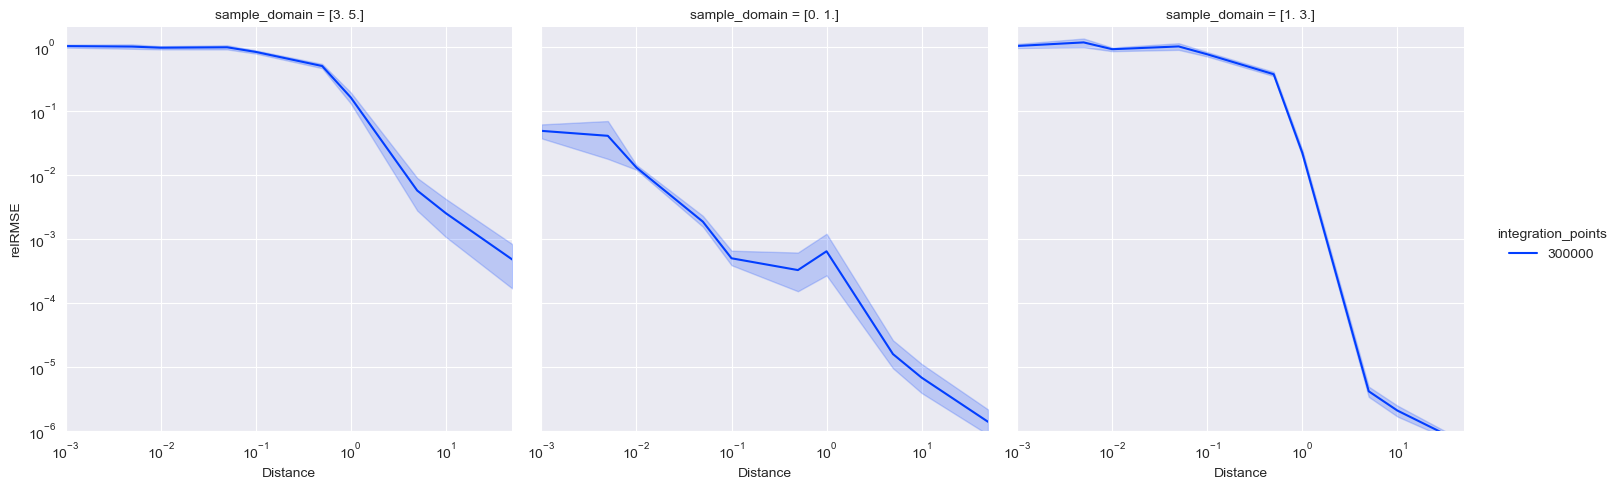

In [8]:
dfm = df.melt(["integration_points", "sample_domain"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["sample_domain"] = dfm["sample_domain"].apply(lambda x: str(x))
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))

g = sns.relplot(
    data=dfm, kind="line",
    col="sample_domain",
    x="Distance", y=error_of_interest,
    hue="integration_points", palette="bright"
)
g.set(
    xlim=(0.001, 50.0), xscale='log', yscale='log', ylim=(1e-6, 2.0)
)
g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_integration_points.png")
g.savefig(save_path, dpi=300)

In [13]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.009337, [9.79917e-05, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 0.093371, [9.79917e-05, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["iterations"] == 10000) & (df["pretrained_model"] == "None") & (df["resolution"] == "100%") & (df["integration_points"] == 300000) & (df["ground_truth"] == "polyhedral")]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "seed", "resolution", "ground_truth", "integration_points", "iterations"], inplace=True)

In [14]:
df_copy = df.copy()
df_copy["sample_domain"] = df_copy["sample_domain"].apply(lambda x: str(x))
df_copy.groupby(["sample_domain", "noise"]).mean()

0.001     0.005  \
sample_domain noise                                                            
[0. 1.]       ['']                                        0.048568  0.040658   
              ['adaptive_gaussian_noise', 0.001]          0.057529  0.023657   
              ['adaptive_gaussian_noise', 0.01]           0.050295  0.043091   
              ['adaptive_gaussian_noise', 0.1]            0.093740  0.077659   
              ['constant_bias', [9.79917e-05, 0.0, 0.0]]  0.050950  0.021419   
              ['gaussian', 0.0, 0.009337]                 0.052647  0.074310   
              ['gaussian', 0.0, 0.093371]                 0.154061  0.096413   
[1. 3.]       ['']                                        1.024505  1.164065   
              ['adaptive_gaussian_noise', 0.001]          0.986181  1.091663   
              ['adaptive_gaussian_noise', 0.01]           1.012108  1.143544   
              ['adaptive_gaussian_noise', 0.1]            0.980983  1.105160   
              ['constant_bias', [9.79917e-05, 0.0, 0.0]]  0.958885  1.094208   
              ['gaussian', 0.0, 0.009337]                 0.957855  1.101159   
              ['gaussian', 0.0, 0.093371]                 1.039149  1.228068   
[3. 5.]       ['']                                        0.976544  0.978659   
              ['adaptive_gaussian_noise', 0.001]          0.981630  1.042519   
              ['adaptive_gaussian_noise', 0.01]           0.977917  1.108285   
              ['adaptive_gaussian_noise', 0.1]            0.909589  1.193104   
              ['constant_bias', [9.79917e-05, 0.0, 0.0]]  0.990824  1.165887   
              ['gaussian', 0.0, 0.009337]                 1.042669  1.159513   
              ['gaussian', 0.0, 0.093371]                 1.174668  1.271191   

                                                              0.01      0.05  \
sample_domain noise                                                            
[0. 1.]       ['']                                        0.012992  0.001861   
              ['adaptive_gaussian_noise', 0.001]          0.013509  0.002320   
              ['adaptive_gaussian_noise', 0.01]           0.017316  0.005357   
              ['adaptive_gaussian_noise', 0.1]            0.052425  0.025221   
              ['constant_bias', [9.79917e-05, 0.0, 0.0]]  0.014793  0.002374   
              ['gaussian', 0.0, 0.009337]                 0.037922  0.005504   
              ['gaussian', 0.0, 0.093371]                 0.092385  0.019087   
[1. 3.]       ['']                                        0.911942  1.006968   
              ['adaptive_gaussian_noise', 0.001]          0.962942  0.993533   
              ['adaptive_gaussian_noise', 0.01]           0.935796  1.022152   
              ['adaptive_gaussian_noise', 0.1]            0.912794  0.922891   
              ['constant_bias', [9.79917e-05, 0.0, 0.0]]  0.875961  0.991048   
              ['gaussian', 0.0, 0.009337]                 0.869397  0.999981   
              ['gaussian', 0.0, 0.093371]                 0.992008  1.085366   
[3. 5.]       ['']                                        0.846568  0.957890   
              ['adaptive_gaussian_noise', 0.001]          0.910713  0.968622   
              ['adaptive_gaussian_noise', 0.01]           0.897318  1.041565   
              ['adaptive_gaussian_noise', 0.1]            0.841648  0.878354   
              ['constant_bias', [9.79917e-05, 0.0, 0.0]]  0.911936  0.956151   
              ['gaussian', 0.0, 0.009337]                 1.006802  0.996166   
              ['gaussian', 0.0, 0.093371]                 1.157971  1.174557   

                                                               0.1       0.5  \
sample_domain noise                                                            
[0. 1.]       ['']                                        0.000500  0.000327   
              ['adaptive_gaussian_noise', 0.001]          0.000900  0.000436   
              ['adaptive_gaussian_noise', 0.01]           0

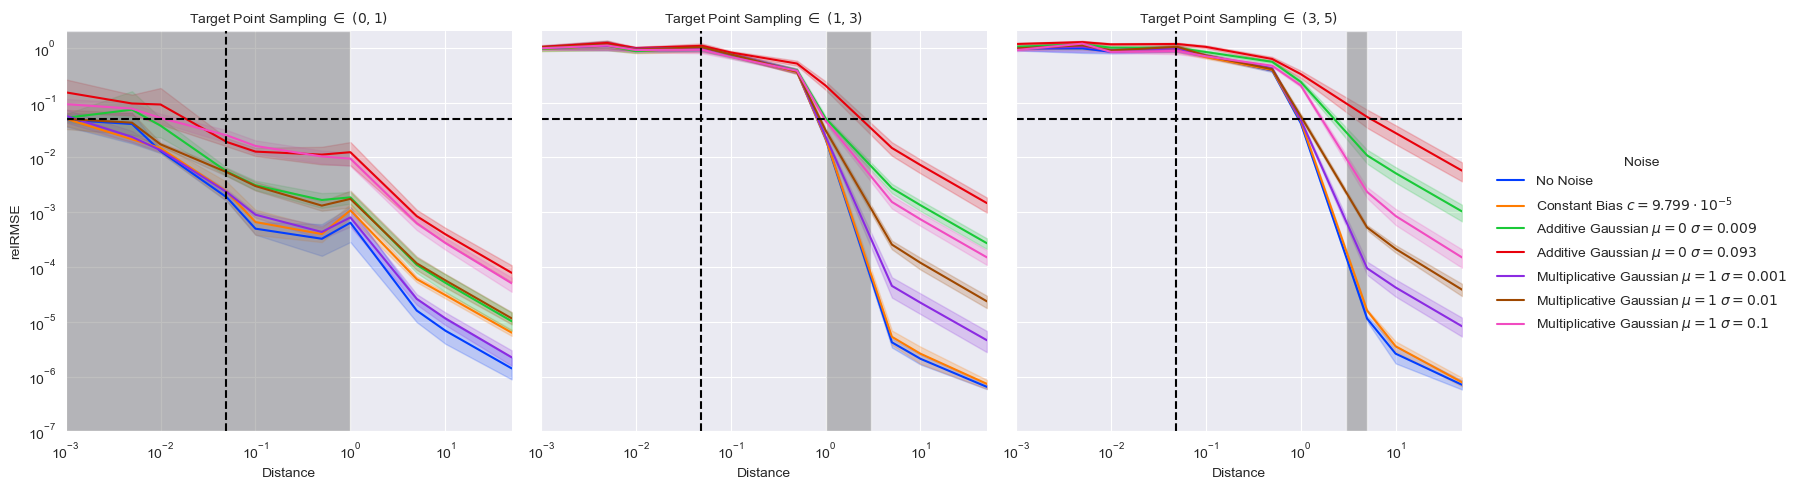

In [9]:
dfm = df.melt(["noise", "sample_domain"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["sample_domain"] = dfm["sample_domain"].apply(lambda x: str(x))
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))

for key, replacement in noise_replacement.items():
    dfm["noise"].replace(key, replacement, inplace=True)

for key, replacement in sample_distance_replacement.items():
    dfm["sample_domain"].replace(key, replacement, inplace=True)

dfm.rename(columns={"sample_domain": "Sample Domain", "noise": "Noise"}, inplace=True)

g = sns.relplot(
    data=dfm, kind="line",
    col="Sample Domain", col_order=sample_distance_replacement.values(),
    x="Distance", y=error_of_interest,
    hue="Noise", palette="bright", hue_order=noise_replacement.values()
)
g.set(
    xlim=(0.001, 50.0), xscale='log', yscale='log', ylim=(1e-7, 2.0)
)

g.set_titles("Target Point Sampling $\in$ {col_name}")

g.map(plt.axhline, y=0.05, ls='--', c='black', label="5%")
g.map(plt.axvline, x=one_km, ls='--', c='black', label="1 km")

g.axes[0,0].axvspan(0, 1.0, facecolor='gray', alpha=0.5)
g.axes[0,1].axvspan(1.0, 3.0, facecolor='gray', alpha=0.5)
g.axes[0,2].axvspan(3.0, 5.0, facecolor='gray', alpha=0.5)

g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_noise.png")
g.savefig(save_path, dpi=300)

In [108]:
dfm

,Noise,Sample Domain,Distance,relRMSE
0,Constant Bias $c = 0.000272$,"$(0, 1)$",0.001,0.036996
1,Additive Gaussian $\mu = 0 \; \sigma= 0.14$,"$(1, 3)$",0.001,0.842197
2,Additive Gaussian $\mu = 0 \; \sigma= 1.47$,"$(3, 5)$",0.001,1.066178
3,Additive Gaussian $\mu = 0 \; \sigma= 1.47$,"$(1, 3)$",0.001,1.199893
4,Constant Bias $c = 0.000272$,"$(1, 3)$",0.001,0.665508
...,...,...,...,...
2095,Multiplicative Gaussian $\mu = 1 \; \sigma= 0.01$,"$(1, 3)$",50.000,0.000017
2096,Multiplicative Gaussian $\mu = 1 \; \sigma= 0.01$,"$(3, 5)$",50.000,0.000028
2097,Multiplicative Gaussian $\mu = 1 \; \sigma= 0....,"$(0, 1)$",50.000,0.000004
2098,Multiplicative Gaussian $\mu = 1 \; \sigma= 0....,"$(1, 3)$",50.000,0.000006
